# Roman Spectroscopy: Grism Spectral Extraction

***

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Imports



In [1]:
import asdf
import roman_datamodels as rdm
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import s3fs

from astropy.table import Table
from scipy.ndimage import rotate
from scipy.interpolate import interp1d
from matplotlib.patches import Circle, Rectangle
from astropy.nddata import Cutout2D
from itertools import cycle
from astropy.convolution import convolve
from astropy.visualization import simple_norm
from photutils.segmentation import detect_sources

%matplotlib inline

## Introduction

In this notebook, we demonstrate an example workflow one can follow to extract the grism spectra from Roman WFI images. We will use simulated grism data for this exercise and illustrate how to go from a full 2-D grism dispersed image to a 1-D spectrum for a source of interest.

**Important Disclaimer:** This workflow is vastly simplified for the purposes of demonstration. This does not represent the full functionality available from the [Grism/Prism Data Processing System (GDPS)]( https://roman.gsfc.nasa.gov/science/roses/GDPSforROSES.pdf), which is the pipeline being developed for reducing Roman WFI spectral data. In the limited demonstration showcased here, we will be making several simplifying assumptions, which will be highlighted by **Notes** throughout the notebook.

### Initial Setup and Utility Functions

Let's begin by setting up a couple utility functions that will be used throughout the notebook:

In [2]:
def get_vmin_vmax(img, fac_neg=1.5, fac_pos=3):
    """
    Returns a min-max value to scale images (when plotting)
    """
    med, std = np.nanmedian(img), np.nanstd(img)
    vmin = med - fac_neg * std
    vmax = med + fac_pos * std
    return vmin, vmax

def cutout_image(image, position, size, fill_value=0):
    """
    Uses the astropy Cutout2D to cutout a part of the image
    """
    return Cutout2D(image, position, size=size, mode="partial", fill_value=fill_value).data

#### Simulated Grism Spectroscopy Data

For this demonstration, we will use the simulated grism images from [Wang et al. (2022, ApJ, 928, 1)](https://ui.adsabs.harvard.edu/abs/2022ApJ...928....1W), developed as part of the Roman High Latitude Spectroscopic Survey (HLSS) Grism Simulation Products. Please refer to [their IRSA page](https://irsa.ipac.caltech.edu/data/theory/Roman/Wang2022a/) for full details on the simulation. Briefly, these simulations cover an area of 4 sq. deg., across a redshift range of $0<z<3$. The simulation products have been designed to closely mimic future observations by incorporating survey parameters from the planned HLSS, such as detection limits, exposure times, roll angles, and dithering.

For this exercise, we provide the direct and grism images for one of the Roman detectors (WFI01) in the ASDF data format for Roman, along with a source catalog.

#### Loading the Simulated Data

Let's load the relevant files:
- WFI direct image corresponding to the grism pointing to locate the on-sky source positions (ASDF format)
- WFI grism image with the slitless spectra (ASDF format)
- Input catalog for the simulated sources (FITS format)

In [3]:
fs = s3fs.S3FileSystem(anon=True)
asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'

# Read in the direct image
asdf_file_uri = asdf_dir_uri + 'r0007601002004013001_0001_wfi01_f158_cal.asdf'
direct_asdf = rdm.open(fs.open(asdf_file_uri, 'rb'))
direct_img = direct_asdf.data

# Read in the grism image
asdf_file_uri = asdf_dir_uri + 'r0007601002004013002_0001_wfi01_grism_cal.asdf'
grism_asdf = rdm.open(fs.open(asdf_file_uri, 'rb'))
grism_img = grism_asdf.data
grism_err = grism_asdf.err

# Read in the catalog
asdf_file_uri = asdf_dir_uri + 'r0007601002004013001_0001_catalog.fits'
hdu = fits.open(asdf_file_uri, fsspec_kwargs={'anon':True})
catalog = Table(hdu[1].data)

#### Initial Quick Look at the Data

Let's first make a quick plot of the direct and dispersed images for visualization. We will also overlay the positions of the sources from the catalog.

##### Getting the Direct-to-Dispersed Mapping

We need to know the mapping between the source position in the direct image and the corresponding spectral trace in the dispersed image. This transformation is part of the Roman "optical model" and will be included in the Roman calibration files, along with utility tools. However, since these tools are still under development, here we provide the spectral trace reference positions and tilts in the catalog (see the `X_GRISM`, `Y_GRISM`, and `THETA_GRISM` columns). 

**NOTE**: The reference position of the spectra we provide is defined at **1.55 microns**. We assume the wavelength dispersion of the Roman grism to be **11 Angstroms per pixel**. WHile the dispersion varies slightly over the wavelength range, we ignore the effects for simplicity.

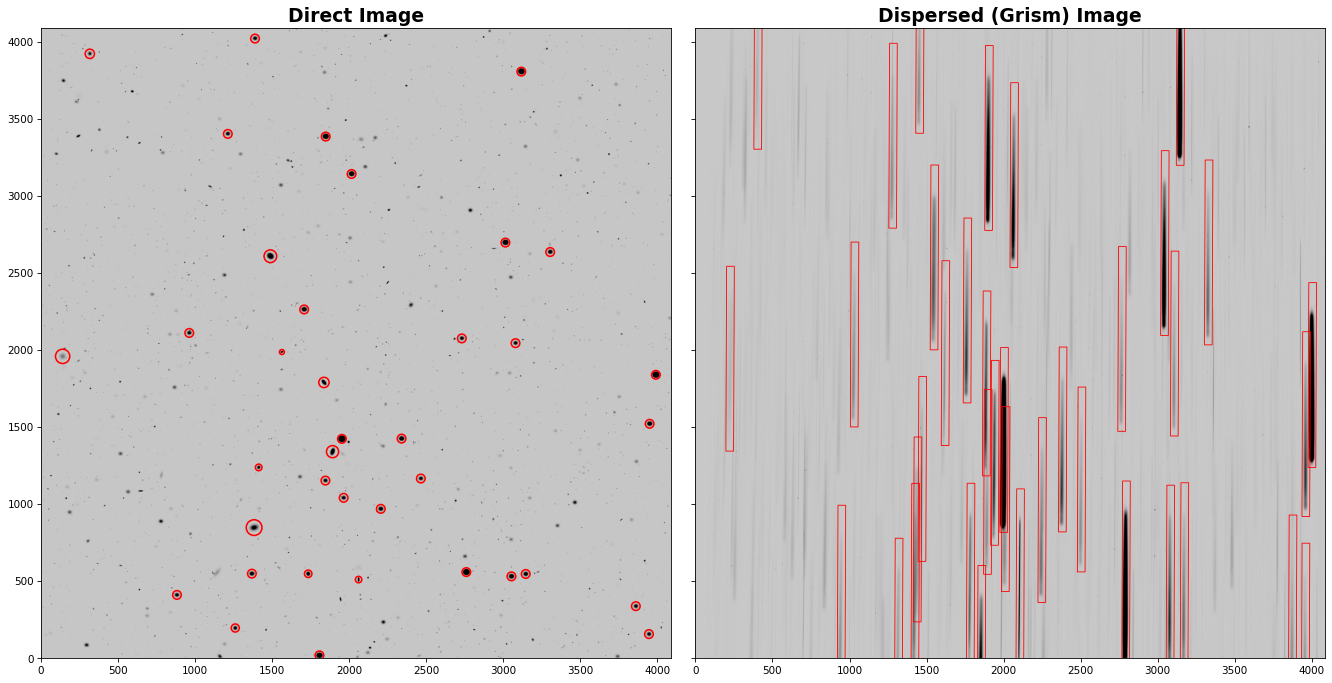

In [4]:
### Setup the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), dpi=75, sharex=True, sharey=True, tight_layout=True)

### Plot the direct image
vmin, vmax = get_vmin_vmax(direct_img)
ax1.imshow(
    direct_img,
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.Greys,
    origin="lower",
)
ax1.set_title("Direct Image", fontsize=18, fontweight=600)

### Plot the grism image
vmin, vmax = get_vmin_vmax(grism_img)
ax2.imshow(
    grism_img,
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.Greys,
    origin="lower",
)
ax2.set_title("Dispersed (Grism) Image", fontsize=18, fontweight=600)

### Overlay the source positions in the direct image
for i, entry in enumerate(catalog[catalog["mag_ROMAN_WFI_NIR_F146"] < 18]): # only show the bright objects
    ax1.add_patch(
        Circle(
            (entry["X_IMAGE"], entry["Y_IMAGE"]),
            radius=entry["A_IMAGE"] * 3.5,
            facecolor="none",
            edgecolor="r",
            lw=1.5,
        )
    )
    bbox = [50, 1200]
    ax2.add_patch(Rectangle((entry["X_GRISM"]-bbox[0]/2, entry["Y_GRISM"]-bbox[1]/2), *bbox, angle=entry["THETA_GRISM"]-90, lw=0.8, facecolor="none", edgecolor='r'))

ax1.set_xlim(0, grism_img.shape[0])
ax1.set_ylim(0, grism_img.shape[1]);

## Cutout of a 2-D Spectrum

Let's now pick an object and make a cutout of its 2-D spectrum. We will also rotate the spectra by its tilt (90 degrees) for visualization, which will make plotting them easier.

**Note:** The process of extracting a 2-D spectral cutout is highly simplified. The spectral traces typically require high-order rectification. For simplicity, we are skipping this step and only considering a rotational transformation. Also, please note that while `scipy.ndimage.rotate()` is convenient, it does not necessarily conserve flux, which is important for proper spectral measurements.

First, we write a function to perform our 2D extraction since this will be utilized again later.

In [5]:
def extract_2D_spectrum(xpix, ypix, theta, size_spatial, grism_img, grism_err, size_wavelength=1200):
    """
    Cutout a 2D spectrum at the desired position for a given size (spatial and spectral dimensions)
    This assumes the spectra are aligned along the y-axis of the dispersed image
    The recommended size in the wavelength dimension is 1200 px
    """
    ### Define the extraction box
    size = [size_spatial, size_wavelength]

    ### Use astropy's Cutout2D
    ### Fill value is set to 0 to avoid issues with rotate
    flux2D = cutout_image(image=grism_img, position=(xpix, ypix), size=size[::-1], fill_value=0)
    ferr2D = cutout_image(image=grism_err, position=(xpix, ypix), size=size[::-1], fill_value=0)

    ### Rotate the vertial spectral just for plotting purposes
    flux2D = rotate(flux2D, theta)
    ferr2D = rotate(ferr2D, theta)

    return flux2D, ferr2D

Let's pick a bright star as our test object -- e.g., ID# 197462 in the catalog.

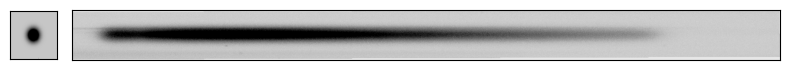

In [6]:
### Let's choose an object
entry = catalog[catalog["SOURCE_ID"]==197462][0]

### Cutout the 2D spectrum
flux2D, ferr2D = extract_2D_spectrum(entry["X_GRISM"], entry["Y_GRISM"], entry["THETA_GRISM"], size_spatial=entry["A_IMAGE"] * 10, grism_img=grism_img, grism_err=grism_err)

### Also cutout a direct image stamp
stamp = rotate(cutout_image(image=direct_img, position=(entry["X_IMAGE"], entry["Y_IMAGE"]), size=flux2D.shape[0]), 90)

### Make a quick plot
fig, axes = plt.subplots(1, 2, figsize=(8, 2), width_ratios=[1, 15], dpi=100, tight_layout=True)

vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

vmin, vmax = get_vmin_vmax(flux2D)
axes[1].imshow(flux2D, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

for axis in axes:
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)

Now that we have a 2D cutout of the spectrum, we need to assign wavelength information.

### Set up the Wavelength Array

Recall that the provided position for the spectral mapping traces to **1.55 microns** and the spectral dispersion for the Roman grism spectrum is **11 Angstroms per pixel** (approximately; see caveats above). With this information we can define a wavelength axis for the extracted spectrum. 

In [7]:
def get_wavelength_info(flux2D):
    """
    Setup spatial and wavelength coordinate arrays
    """
    grism_dispersion = 0.0011 # micron / px (approximately)
    grism_zeropoint = 1.55 # micron

    idx2D, idy2D = np.indices(flux2D.shape)
    idx2D = idx2D - flux2D.shape[0] / 2
    idy2D = idy2D - flux2D.shape[1] / 2

    wave2D = idy2D * grism_dispersion + grism_zeropoint

    return idx2D, wave2D

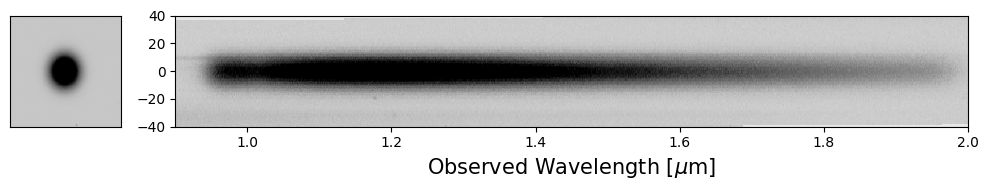

In [8]:
### Make a quick plot
fig, axes = plt.subplots(1, 2, figsize=(10, 2), width_ratios=[1, 7], dpi=100, tight_layout=True)

vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)

vmin, vmax = get_vmin_vmax(flux2D)
idx2D, wave2D = get_wavelength_info(flux2D=flux2D)
axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

axes[1].set_xlim(0.9, 2.0)
axes[1].set_ylim(-40, 40)
axes[1].set_xlabel("Observed Wavelength [$\\mu$m]", fontsize=15);

Now, we move to the 1-D spectral extraction.

### Box Extraction

The simplest and most straightforward way to extract a 1-D spectrum from our 2-D cutout is to use the "Box extraction" method, by defining a window around the trace and summing up the flux along the spatial dimension. The dimension of the box window has a significant impact on the extracted spectrum -- it needs to be large enough to capture all the flux from the source, but not too large to include excessive amounts of noise which would degrade the quality of the 1-D spectrum. As an initial approach, we can define the size of the extraction box based on the size of the source measured from the direct image. We'll use the semi-major axis length from the catalog, scaled by a scalar factor, to explore how the window size affects the extracted 1-D spectrum.

In [9]:
def do_box_extraction(idx2D, wave2D, flux2D, ferr2D, extract_size):
    """
    Perform a box extraction
    """
    cond = np.abs(idx2D[:,0]) < extract_size / 2
    wave1D = np.nanmean(wave2D, axis=0)
    flux1D = np.nansum(flux2D[cond, :], axis=0)
    ferr1D = np.sqrt(np.nansum(ferr2D[cond, :]**2, axis=0))

    return wave1D, flux1D, ferr1D

Let's use a range of box sizes for the 1D extraction and see how it performs for our target.

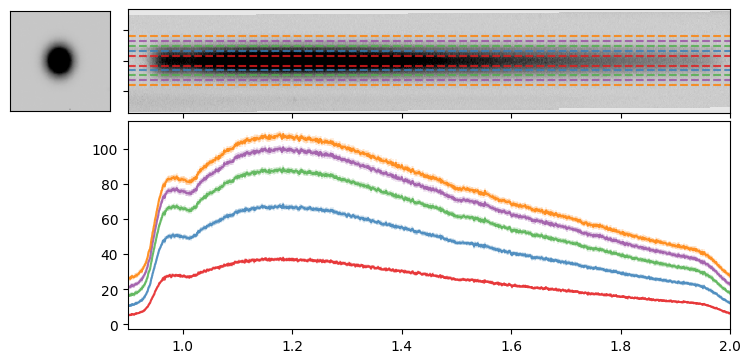

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), width_ratios=[1, 6], height_ratios=[1, 2], dpi=100)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.05, hspace=0.05)
axes = axes.flatten()
axes[2].set_visible(False)

# Plot the direct image stamp
vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)

# Plot the 2D spectrum
vmin, vmax = get_vmin_vmax(flux2D)
axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[1].set_xlim(0.9, 2.0)
[label.set_visible(False) for label in axes[1].get_yticklabels() + axes[1].get_xticklabels()]

color_cycle = cycle(plt.cm.Set1.colors)
for factor in [1, 2, 3, 4, 5]:
    color = next(color_cycle)
    wave1D, flux1D, ferr1D = do_box_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, extract_size=entry["A_IMAGE"]*factor)
    axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, marker='o', color=color, lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
    axes[1].hlines([-entry["A_IMAGE"]*factor/2, entry["A_IMAGE"]*factor/2], *axes[1].get_xlim(), color=color, lw=1.5, ls='--', alpha=0.8)
axes[3].set_xlim(axes[1].get_xlim());

As noted above, the size of the extraction box is crucial. If it is too small, it may miss flux from the true source; if it is too large, it may include excessive noise, reducing the overall quality of the resulting spectrum. Therefore, we turn to the optimal extraction method.

### Optimal Extraction

[Horne (1986, PASP, 98, 609)](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract) provides an algorithm to optimally extract a 1-D spectrum. To run the optimal extraction, we need the source 1-D profile in the spatial dimension, that we can obtain from the WFI direct image.

First, let's write up a quick function to implement the Horne+86 algorithm.

In [11]:
def do_optimal_extraction(idx2D, wave2D, flux2D, ferr2D, stamp):
    """
    Performs optimal extraction following Horne+86
    """
    # Generate a 1D light profile for the source from the direct image
    stamp = stamp - np.median(stamp)
    prof1D = np.nansum(stamp, axis=1)
    prof1D = prof1D / np.sum(prof1D)
    prof2D = np.repeat(prof1D, flux2D.shape[1]).reshape(len(prof1D), flux2D.shape[1])

    # Apply some basic masking
    mask = ~np.isfinite(flux2D) | ~np.isfinite(ferr2D) | (ferr2D<=0)
    flux2D = np.ma.masked_array(flux2D, mask=mask)
    ferr2D = np.ma.masked_array(ferr2D, mask=mask)

    # Compute the relevant terms for the Horne+86 algorithm
    ivar2D = 1 / ferr2D**2
    num2D = ivar2D * prof2D * flux2D
    den2D = ivar2D * prof2D**2

    # Compute the final wavelength and flux arrays
    wave1D = np.mean(wave2D, axis=0)
    flux1D = np.ma.sum(num2D, axis=0) / np.ma.sum(den2D, axis=0)
    ferr1D = np.ma.sqrt(1 / np.ma.sum(den2D, axis=0))

    return wave1D, flux1D.filled(np.nan), ferr1D.filled(np.nan)

Let's apply this optimal extraction to our target and compare the two extraction methods.

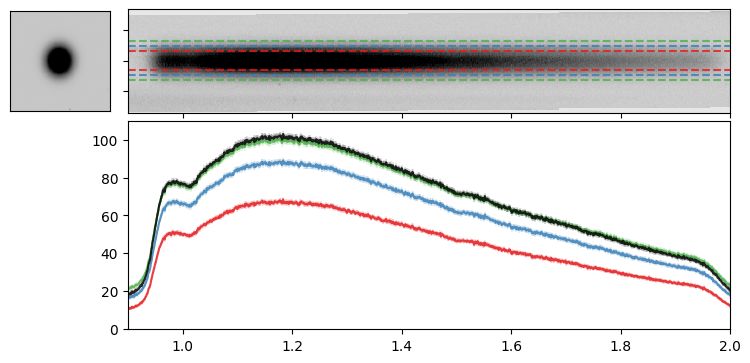

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), width_ratios=[1, 6], height_ratios=[1, 2], dpi=100)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.05, hspace=0.05)
axes = axes.flatten()
axes[2].set_visible(False)

# Plot the direct image stamp
vmin, vmax = get_vmin_vmax(stamp)
axes[0].imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)

# Plot the 2D spectrum
vmin, vmax = get_vmin_vmax(flux2D)
axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
axes[1].set_xlim(0.9, 2.0)
[label.set_visible(False) for label in axes[1].get_yticklabels() + axes[1].get_xticklabels()]

color_cycle = cycle(plt.cm.Set1.colors)
for factor in [2, 3, 4]:
    color = next(color_cycle)
    wave1D, flux1D, ferr1D = do_box_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, extract_size=entry["A_IMAGE"]*factor)
    axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, marker='o', color=color, lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
    axes[1].hlines([-entry["A_IMAGE"]*factor/2, entry["A_IMAGE"]*factor/2], *axes[1].get_xlim(), color=color, lw=1.5, ls='--', alpha=0.8)

wave1D, flux1D, ferr1D = do_optimal_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, stamp=stamp)
axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, color='k', marker='o', lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)

axes[3].set_xlim(axes[1].get_xlim());

#### Masking Neighboring Sources in Direct Cutouts

It is essential to properly mask neighboring sources before generating the 1-D light profile for the target. Failing to do so will result in an inaccurate 1-D spectrum. To address it, we can use a `photutils` source detection function on the stamp and apply it to mask out any other sources within the region.

While our target does not require this step, it will be necessary for other sources discussed below.

In [13]:
grism_img_thresh = np.std(grism_img)
grism_img_skybkg = np.median(grism_img) / 2

def mk_segmented_stamp(data, skybkg=grism_img_skybkg, thresh=grism_img_thresh*0.8):

    if skybkg is None:
        skybkg = np.median(data)
    if thresh is None:
        thresh = np.std(data) / 2

    segm = detect_sources(data-skybkg, thresh, npixels=5).data

    data_segm = data.copy()
    idx = [i // 2 for i in segm.shape]
    data_segm[(segm!=segm[*idx]) & (segm>0)] = 0
    return data_segm

### Full Workflow: Grism Image to Extracted 1-D Spectrum

Now that we have demonstrated all the steps, let's combine them into a single workflow that performs the full 1-D extraction and apply it multiple sources.

In [14]:
def do_full_extraction(entry, direct_img, grism_img, grism_err, size_factor=10, box_size_factor=None, plot=True):
    """
    Performs the full 1D spectral extraction workflow for a given object provided as a row from the catalog
    Requires X_IMAGE, Y_IMAGE, A_IMAGE, X_GRISM, Y_GRISM columns from the catalog
    Also requires the direct and grism images
    Optionally produces plots
    """
    # Start by extracting the 2D spectrum
    size_spatial = np.clip(entry["A_IMAGE"] * size_factor, 10, 500)
    flux2D, ferr2D = extract_2D_spectrum(entry["X_GRISM"], entry["Y_GRISM"], entry["THETA_GRISM"], size_spatial=size_spatial, grism_img=grism_img, grism_err=grism_err)

    # Generate a stamp for the source from the direct image and also mask other objects in the stamp
    stamp = rotate(cutout_image(image=direct_img, position=(entry["X_IMAGE"], entry["Y_IMAGE"]), size=flux2D.shape[0]), 90)
    stamp_masked = mk_segmented_stamp(data=stamp)

    # Generate the wavelength info
    idx2D, wave2D = get_wavelength_info(flux2D=flux2D)

    # Generate the 1D spectrum with optimal extraction
    wave1D, flux1D, ferr1D = do_optimal_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, stamp=stamp_masked)

    # (optionally) Generate a plot to show of the spectrum and also box extraction results
    if plot:
        # Setup the subplots
        fig, axes = plt.subplots(2, 2, figsize=(12, 4), width_ratios=[1, 6], height_ratios=[2, 3], dpi=100)
        fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.05, hspace=0.05)
        axes = axes.flatten()
        axes[2].set_visible(False)

        # Plot the direct image stamp
        vmin, vmax = get_vmin_vmax(stamp_masked)
        axes[0].imshow(stamp_masked, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
        axes[0].xaxis.set_visible(False)
        axes[0].yaxis.set_visible(False)

        # Plot the 2D spectrum
        vmin, vmax = get_vmin_vmax(flux2D[int(flux2D.shape[0] / 4) : int(flux2D.shape[0] * 3 / 4), :])
        axes[1].pcolormesh(wave2D, idx2D, flux2D, vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
        axes[1].set_xlim(0.9, 1.9)
        [label.set_visible(False) for label in axes[1].get_yticklabels() + axes[1].get_xticklabels()]

        # Plot box extraction
        color_cycle = cycle(plt.cm.Set1.colors)
        _flux1D_for_ylim = []
        if box_size_factor is not None:
            for factor in np.atleast_1d(box_size_factor):
                color = next(color_cycle)
                _wave1D, _flux1D, _ferr1D = do_box_extraction(idx2D=idx2D, wave2D=wave2D, flux2D=flux2D, ferr2D=ferr2D, extract_size=entry["A_IMAGE"]*factor)
                axes[3].errorbar(_wave1D, _flux1D, yerr=_ferr1D, marker='o', lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
                axes[1].hlines([-entry["A_IMAGE"]*factor/2, entry["A_IMAGE"]*factor/2], *axes[1].get_xlim(), color=color, lw=1.5, ls='--', alpha=0.8)
                _flux1D_for_ylim = np.append(_flux1D_for_ylim, _flux1D[(np.abs(wave1D-1.5) < 0.4) & (_flux1D > 0)])

        # Plot Optical extraction
        axes[3].errorbar(wave1D, flux1D, yerr=ferr1D, color='k', marker='o', lw=1.5, mew=0, markersize=0, elinewidth=0.2, capsize=0, alpha=0.8)
        axes[3].set_xlim(axes[1].get_xlim())

        # Plot decorations and axis limits
        flux1D_for_ylim = flux1D[(np.abs(wave1D-1.5) < 0.4) & (flux1D > 0)]
        flux1D_for_ylim = np.append(flux1D_for_ylim, _flux1D_for_ylim)
        ylim = np.nanpercentile(flux1D_for_ylim, [1, 100])
        axes[3].set_ylim(0, ylim[1]*1.3)
        axes[3].set_ylabel("Flux [DN/s]", fontsize=14)
        axes[3].set_xlabel("Wavelength [$\\mu$m]", fontsize=14)
        axes[3].text(0.995, 0.98, f"ID#{entry['SOURCE_ID']:d}", va="top", ha="right", color="k", fontsize=18, transform=axes[3].transAxes)

    return {"stamp": stamp,
            "flux2D": flux2D, "ferr2D": ferr2D, "idx2D": idx2D, "wave2D": wave2D,
            "wave1D": wave1D, "flux1D": flux1D, "ferr1D": ferr1D}

## Examples of Bright Stars

Let's start with some examples of bright stars, IDs: 46656, 197387, 197396, 197413, 197418, 197462, 197484, 197503, 197585, 197590, 197592, 197594

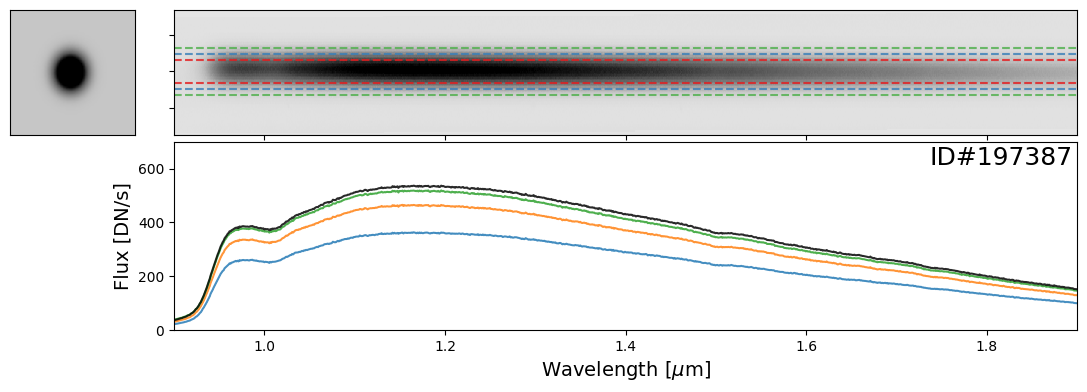

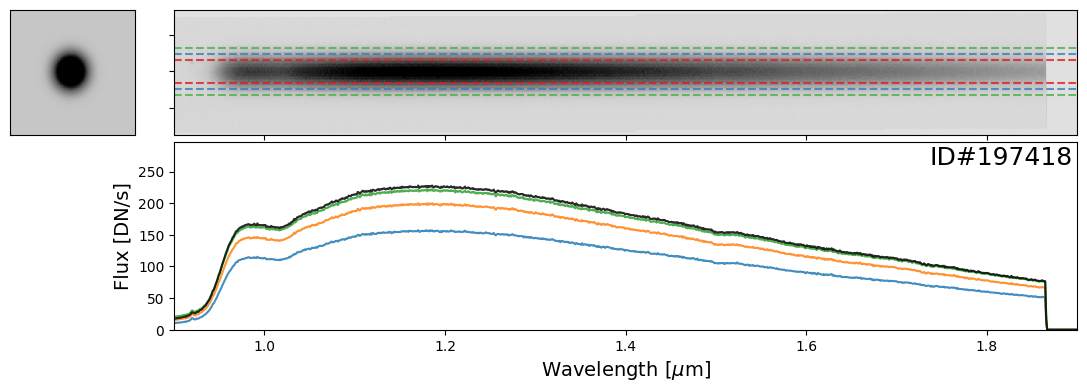

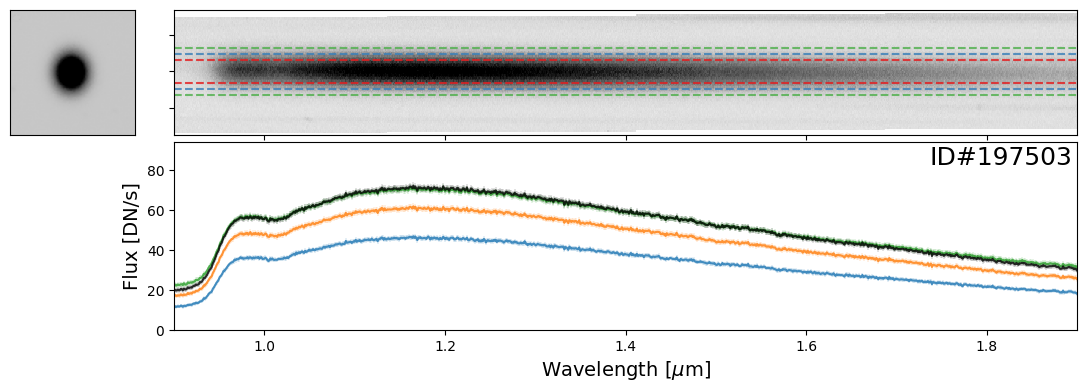

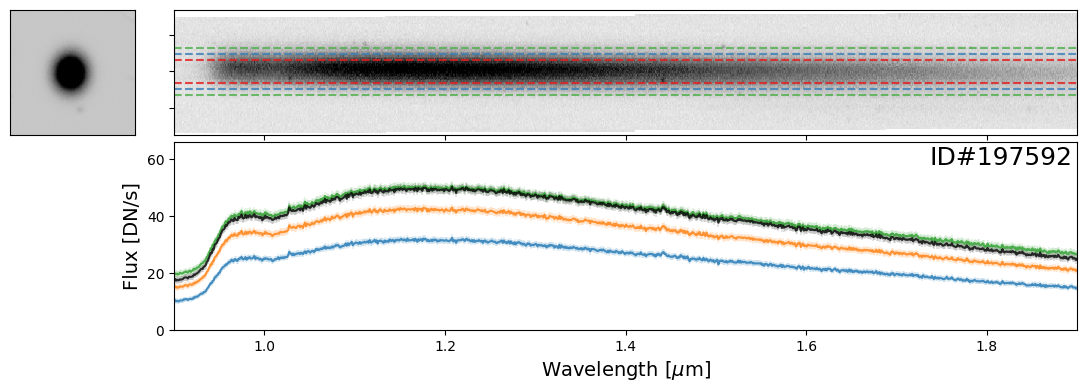

In [15]:
star_IDs = [197387, 197396, 197413, 197418, 197462, 197484, 197503, 197585, 197590, 197592, 197594]
for star_ID in star_IDs[::3]:   # Only showing a subset; increase as needed
    entry = catalog[catalog["SOURCE_ID"]==star_ID][0]
    do_full_extraction(entry, direct_img, grism_img, grism_err, box_size_factor=[2, 3, 4], plot=True)

## Examples of Galaxies

Now let's take a look at some galaxies. Here you can experiment with whichever objects you want from the source catalog. For demonstration purposes, we have provided a few select examples that highlight interesting spectral features.

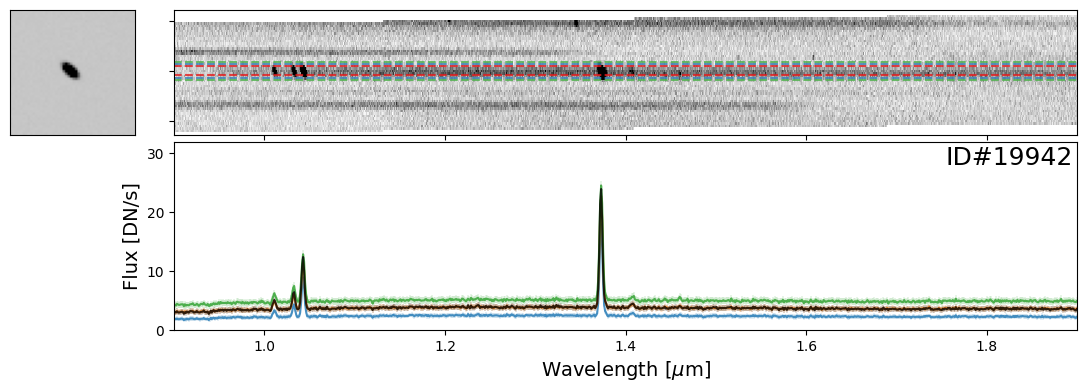

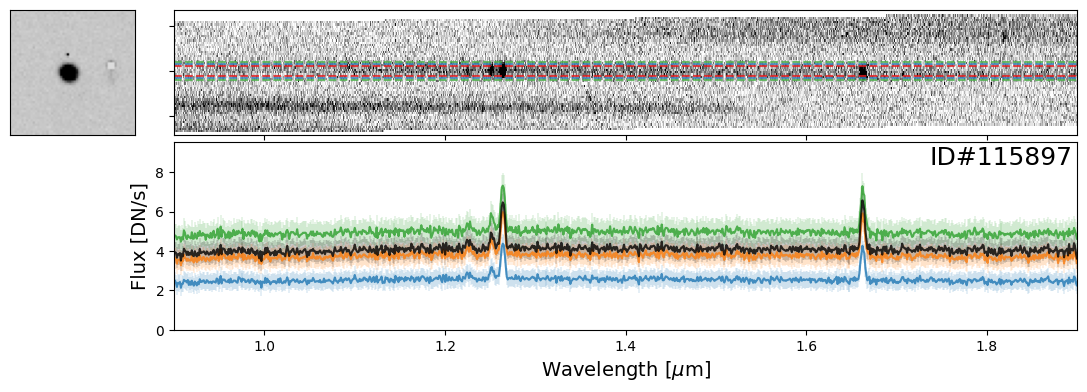

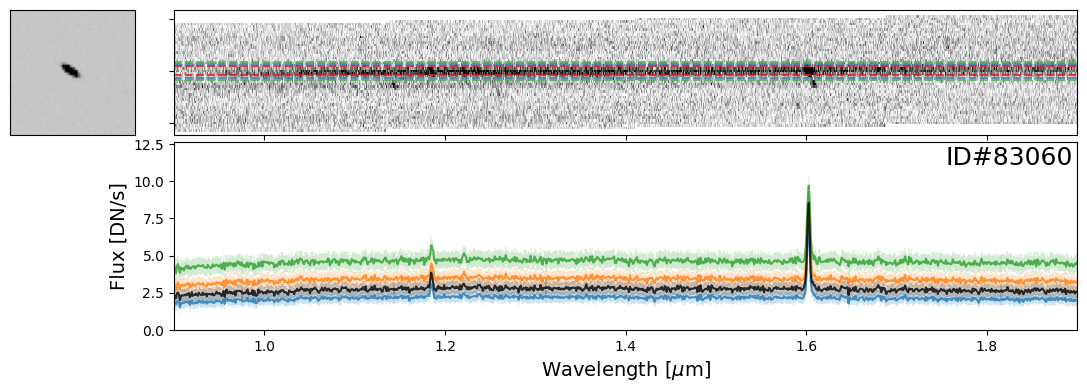

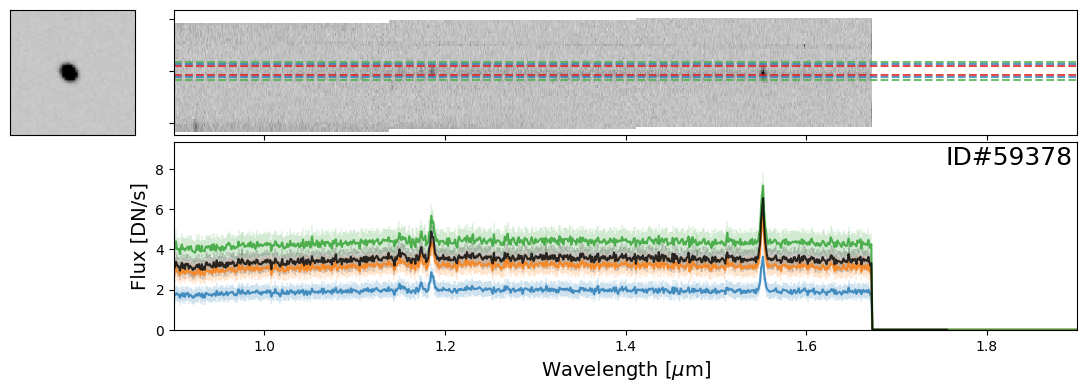

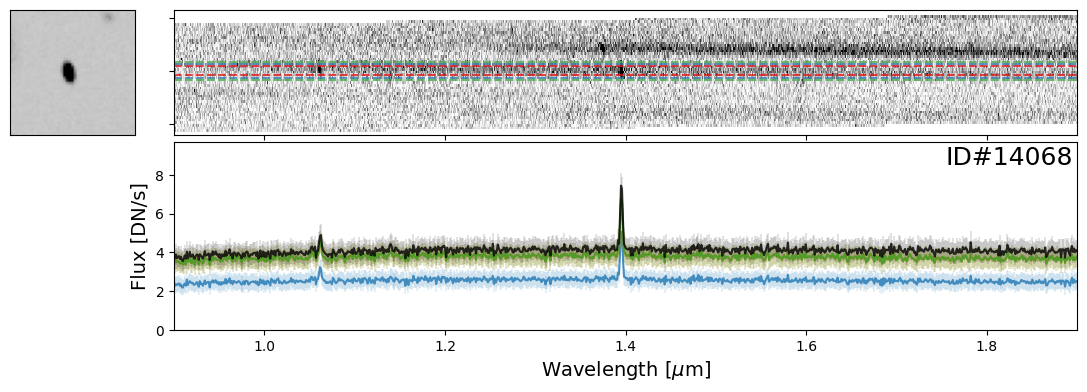

In [16]:
galaxy_IDs = [19942, 115897, 83060, 59378, 14068]
for source_ID in galaxy_IDs:
    entry = catalog[catalog["SOURCE_ID"]==source_ID][0]
    do_full_extraction(entry, direct_img, grism_img, grism_err, size_factor=25, box_size_factor=[2, 3, 4], plot=True)

## Examples of Nearby Emission Line Galaxies

Here are a couple examples of emission line galaxies that are close enough to see the emission lines from the neighboring object in the extracted 2-D spectrum.

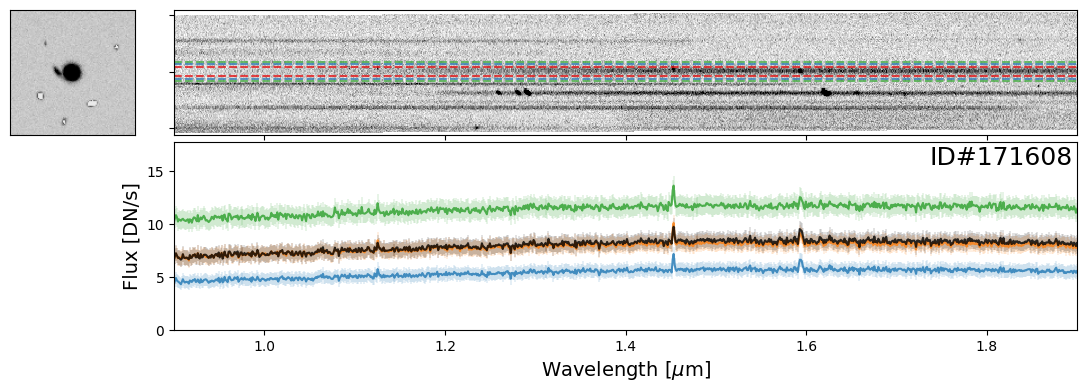

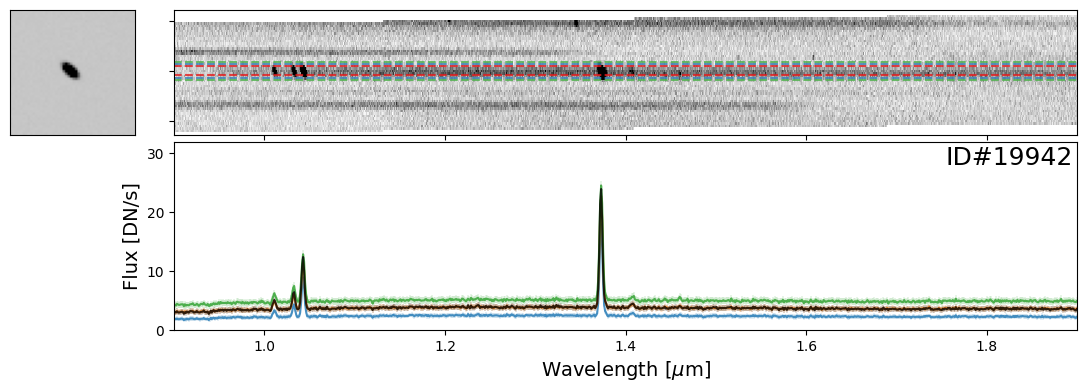

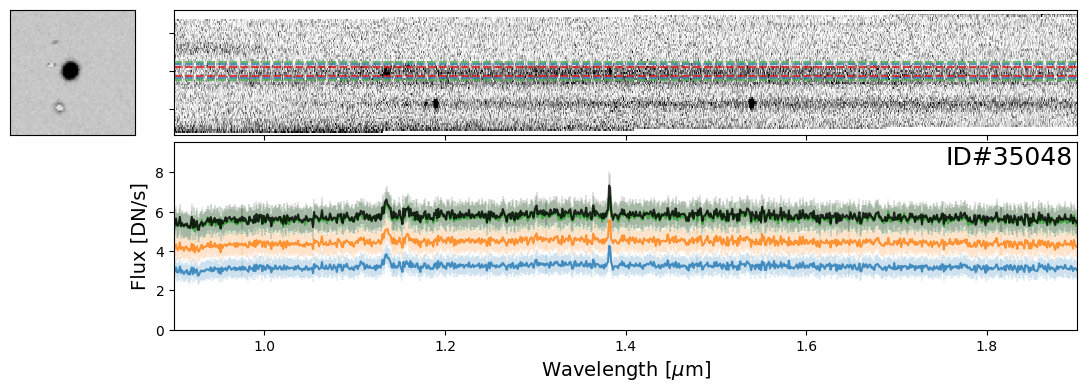

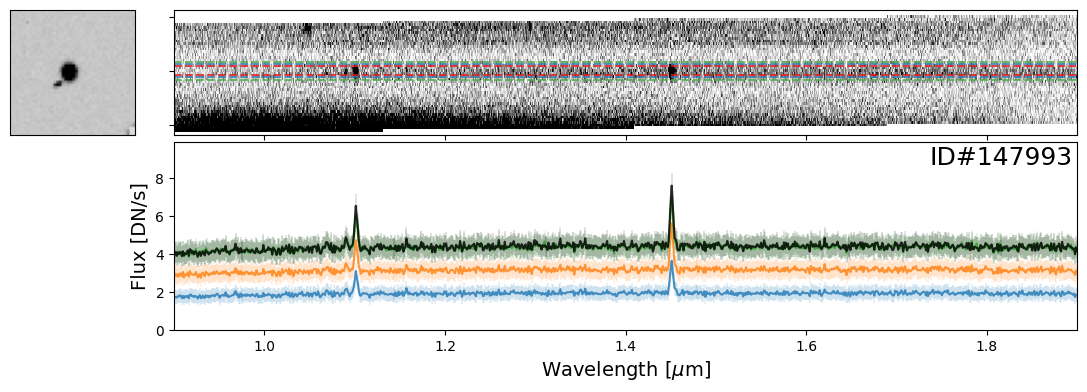

In [17]:
pairs_IDs = [171608, 19942, 35048, 147993]
for source_ID in pairs_IDs:
    entry = catalog[catalog["SOURCE_ID"]==source_ID][0]
    do_full_extraction(entry, direct_img, grism_img, grism_err, size_factor=25, box_size_factor=[2, 3, 4], plot=True)

## Example of Overlapping Spectra

Here is an example of two spectra, one from a star (ID#197738) and another from a bright, high-redshift emission line galaxy (ID#166231), that happen to overlap.

In this case, it is imperative to perform a "decontamination" to accurately recover the true flux of the individual source. This is a non-trivial process and this functionality will be available in the Roman GDPS pipeline.

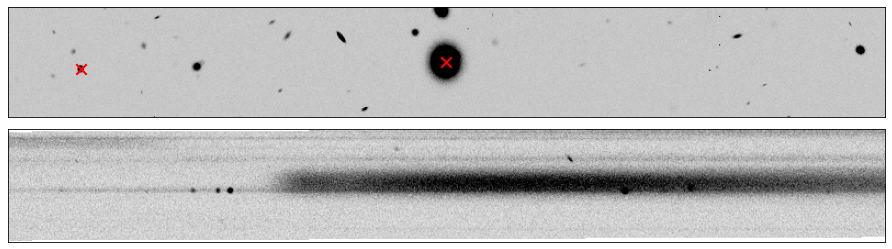

In [18]:
entry_str = catalog[catalog["SOURCE_ID"]==197738][0]
entry_gal = catalog[catalog["SOURCE_ID"]==166231][0]

stamp = rotate(cutout_image(image=direct_img, position=(entry_str["X_IMAGE"], entry_str["Y_IMAGE"]), size=[800, 100]), 90)
flux2D = rotate(cutout_image(image=grism_img, position=(entry_str["X_GRISM"], entry_str["Y_GRISM"]-400), size=[800, 100]), entry_str["THETA_GRISM"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,3.5), dpi=75, tight_layout=True)

vmin, vmax = get_vmin_vmax(stamp)
ax1.imshow(stamp, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)
ax1.scatter(stamp.shape[1]/2 - 1, stamp.shape[0]/2 - 1, color="r", marker="x", lw=2, s=100)
ax1.scatter(stamp.shape[1]/2 - 1 + (entry_gal["Y_IMAGE"]-entry_str["Y_IMAGE"]),
            stamp.shape[0]/2 - 1 - (entry_gal["X_IMAGE"]-entry_str["X_IMAGE"]), color="r", marker="x", lw=2, s=100)

vmin, vmax = get_vmin_vmax(flux2D)
ax2.imshow(flux2D, origin="lower", vmin=vmin, vmax=vmax, cmap=plt.cm.Greys)

for ax in [ax1, ax2]:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

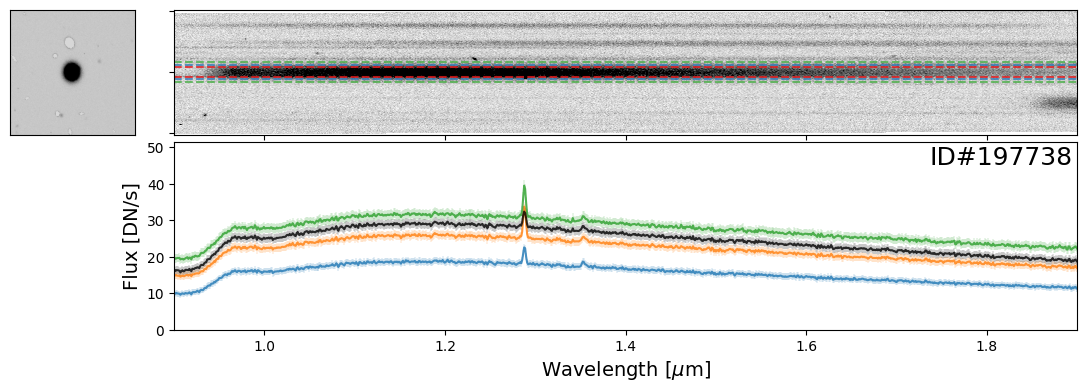

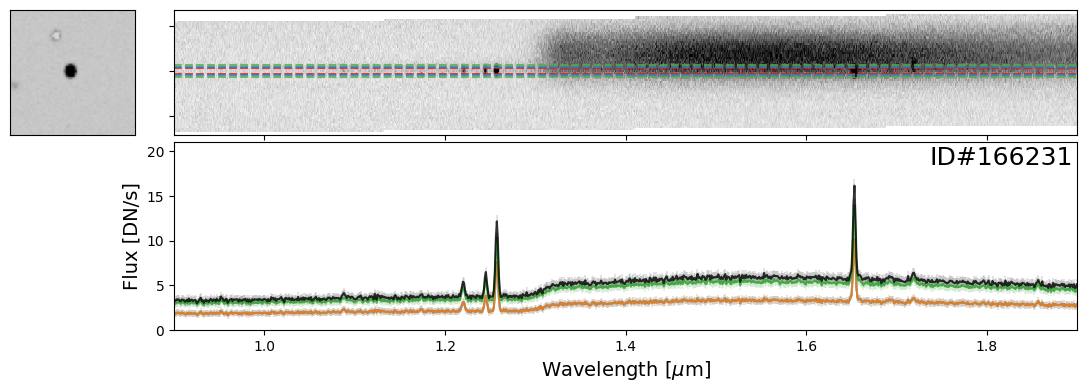

In [19]:
do_full_extraction(entry_str, direct_img, grism_img, grism_err, size_factor=25, box_size_factor=[2, 3, 4], plot=True)
do_full_extraction(entry_gal, direct_img, grism_img, grism_err, size_factor=40, box_size_factor=[2, 3, 4], plot=True);

## Additional Resources

- [GDPS Presentation](https://roman.gsfc.nasa.gov/science/roses/GDPSforROSES.pdf])

## About this Notebook

**Author:** Vihang Mehta\
**Updated On:** 2025-09-30

---